In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.dataset import random_split
from torchvision import datasets
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

In [57]:
##Do Not Touch This Cell

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        self.softmax = nn.LogSoftmax(dim = 1)
  
    def forward(self, x):
    
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = self.softmax(x)
        return output

In [58]:
##Do Not Touch This Cell

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = Net()
net = net.to(device)
optimizer = optim.SGD(net.parameters(), lr=.01,
                      momentum=0.5)
if device =='cuda':
    print("Train on GPU...")
else:
    print("Train on CPU...")

Train on CPU...


In [59]:
##Do Not Touch This Cell

max_epochs = 30
batch_size_train = 64
batch_size_test = 1


random_seed = 671
torch.manual_seed(random_seed)

In [60]:
train_set = datasets.MNIST('mnist_data', train=True, download=True,
         transform=torchvision.transforms.ToTensor())
        
test_set =  datasets.MNIST('mnist_data', train=False, download=True,
         transform=torchvision.transforms.ToTensor())
                           
all_MNIST = train_set + test_set

##TODO: Split the set into 50% train, 50% test (there are 70K total images)
train_amt = int(len(all_MNIST) * 0.5)
test_amt = len(all_MNIST) - train_amt
train_set, test_set = random_split(all_MNIST,[train_amt, test_amt])


train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size_test, shuffle=True)


In [61]:
##TODO: Implement Training Loop
##Make sure to keep track of avg epoch losses in lists

criterion = nn.CrossEntropyLoss()
def train(net):
    losses = []
    
    #TODO: set net to train mode
    net.train()
    for epoch in range(max_epochs):
        print('Epoch:', epoch + 1)
        epoch_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
    
            optimizer.zero_grad()
            ##TODO: pass the data into the network and store the output 
            data = data.to(device)
            target = target.to(device)

            outputs = net(data)
            ##TODO: Calculate the negative log likelihood between the output and target 
            loss = criterion(outputs, target)
            
            ##TODO: Perform backpropagation 
            loss.backward()
            
            optimizer.step()

            ##TODO: Add the loss to epoch_loss.
            ##HINT: the loss variable is currently a tensor. Use loss.item() 
            ##to get the scalar value
            epoch_loss += loss
            
        #TODO: append average epoch loss to losses list  
        avg_loss = epoch_loss / (batch_idx + 1)
        print(avg_loss)
        losses.append(avg_loss)
            
            
    return losses


In [62]:
losses = train(net)

Epoch: 1
tensor(0.6263, grad_fn=<DivBackward0>)
Epoch: 2
tensor(0.2244, grad_fn=<DivBackward0>)
Epoch: 3
tensor(0.1646, grad_fn=<DivBackward0>)
Epoch: 4
tensor(0.1336, grad_fn=<DivBackward0>)
Epoch: 5
tensor(0.1117, grad_fn=<DivBackward0>)
Epoch: 6
tensor(0.0981, grad_fn=<DivBackward0>)
Epoch: 7
tensor(0.0866, grad_fn=<DivBackward0>)
Epoch: 8
tensor(0.0790, grad_fn=<DivBackward0>)
Epoch: 9
tensor(0.0691, grad_fn=<DivBackward0>)
Epoch: 10
tensor(0.0630, grad_fn=<DivBackward0>)
Epoch: 11
tensor(0.0567, grad_fn=<DivBackward0>)
Epoch: 12
tensor(0.0512, grad_fn=<DivBackward0>)
Epoch: 13
tensor(0.0469, grad_fn=<DivBackward0>)
Epoch: 14
tensor(0.0429, grad_fn=<DivBackward0>)
Epoch: 15
tensor(0.0379, grad_fn=<DivBackward0>)
Epoch: 16
tensor(0.0348, grad_fn=<DivBackward0>)
Epoch: 17
tensor(0.0307, grad_fn=<DivBackward0>)
Epoch: 18
tensor(0.0285, grad_fn=<DivBackward0>)
Epoch: 19
tensor(0.0242, grad_fn=<DivBackward0>)
Epoch: 20
tensor(0.0230, grad_fn=<DivBackward0>)
Epoch: 21
tensor(0.0207, grad

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

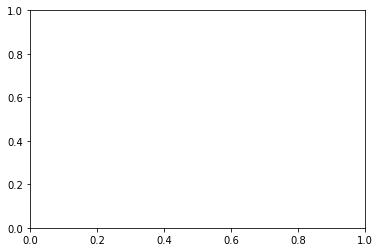

In [63]:
##TODO: Plot losses
##Make sure to label axes
x = np.linspace(1, len(losses), num=len(losses))
plt.plot(x, losses)
plt.show()
plt.close()

When does the network start to converge?


The network starts to converge in about epoch 10 to 15. 
In these epoches, the loss decreases, so the loss is 0.1 to 0.

In [64]:
##Test on the test set and get the confusion matrix

def get_confusion_matrix(net):
    predictions = []
    targets = []

    #TODO: set network to evaluation mode
    net.eval()
   
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            ##TODO: pass the data into the network and update predictions and target list
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            
            outputs = net(data)
            _, predicted = outputs.max(1)
            
            ##TODO: update predictions list and targets list
            predictions.append(predicted)
            targets.append(target)
        
            if batch_idx % 5000 == 0:
                print('Finished Image #', batch_idx)

    predictions = [element.cpu().numpy() for element in predictions]
    predictions = np.asarray(predictions).flatten()
    targets = [element.cpu().numpy() for element in targets]
    targets = np.asarray(targets).flatten() 
    
    return confusion_matrix(targets, predictions), np.array(predictions), np.array(targets)

In [65]:
def get_confusion_matrix_train(net):
    predictions = []
    targets = []

    #TODO: set network to evaluation mode
    net.eval()
   
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(train_loader):
            ##TODO: pass the data into the network and update predictions and target list
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            # Generate output from the DNN.
            outputs = net(data)
            _, predicted = outputs.max(1)
            ##TODO: update predictions list and targets list
            for item in predicted.cpu().numpy():
                predictions.append(item)
            for item in target.cpu().numpy():
                targets.append(item)
        
            if batch_idx % 5000 == 0:
                print('Finished Image #', batch_idx)

    predictions = np.asarray(predictions).flatten()
    targets = np.asarray(targets).flatten()
    
    return confusion_matrix(targets, predictions), np.array(predictions), np.array(targets)

In [66]:
##TODO: print Confusion matrix
confusion, predictions, targets = get_confusion_matrix(net)
print('test confusion matrix:')
print(confusion)
print()
confusion, predictions_train, targets_train = get_confusion_matrix_train(net)
print('train confusion matrix:')
print(confusion)

Finished Image # 0
Finished Image # 5000
Finished Image # 10000
Finished Image # 15000
Finished Image # 20000
Finished Image # 25000
Finished Image # 30000
test confusion matrix:
[[3441    4    3    0    0    5    5    4   21    6]
 [   0 3950    2    2    0    0    2    5    4    3]
 [  13   10 3413   11    4    1    3   22   19    4]
 [   5   10   21 3475    0   19    1   11   26   12]
 [   3   15    5    0 3345    1   12    4    7   35]
 [   3    2    2    8    0 3090   13    1   16   15]
 [  13    4    1    1    6    4 3347    0   10    0]
 [   1   12   16    6    5    0    0 3571    6   22]
 [   5   21    4   11    4   15    7    5 3302   13]
 [   4    5    1   14   14    9    2   23   11 3391]]

Finished Image # 0
train confusion matrix:
[[3414    0    0    0    0    0    0    0    0    0]
 [   0 3908    0    0    0    0    0    1    0    0]
 [   1    2 3483    0    0    0    0    4    0    0]
 [   0    0    0 3556    0    0    0    1    4    0]
 [   0    1    0    0 3391    0   

In [67]:
##TODO: Compute Accuracy
correct_examples = (predictions == targets).sum()
acc = correct_examples / len(predictions)
print('Testing Accuracy =', acc)

correct_examples = (predictions_train == targets_train).sum()
acc = correct_examples / len(predictions)
print('Training Accuracy =', acc)

Testing Accuracy = 0.9807142857142858
Training Accuracy = 0.9986571428571429


Which images seems to get confused the most? Intiutively, why does that make sense?

The image of 5 is the most confused one. In my opinion, it was confused because the shape of 5 is similar to 6 or 9.
The machine couldn't classify it very well.

In [68]:
##For convenience, here is the dataset in flattened numpy arrays for the rest of problem

trainset_list = list(zip(*train_set))
X_train = np.array([trainset_list[0][index].numpy().flatten() for index in range(train_amt)])

Y_train = np.array([trainset_list[1][index] for index in range(train_amt)])

testset_list = list(zip(*test_set))
X_test = np.array([testset_list[0][index].numpy().flatten() for index in range(test_amt)])

Y_test = np.array([testset_list[1][index] for index in range(test_amt)])

In [69]:
##TODO: Fit a logistic regression model on the training set

clf = LogisticRegression(random_state=0, max_iter=10000).fit(X_train, Y_train)
predicted_test = clf.predict(X_test)

predicted_train = clf.predict(X_train)

print('Finish training logistic regression .....')


Finish training logistic regression .....


In [78]:
##TODO: For both the training and test set, get their confusion matrices and accuracies

confusion_train = confusion_matrix(Y_train, predicted_train)
correct_examples = (predicted_train == Y_train).sum()
acc = correct_examples / len(predictions)
print('Training Accuracy =', acc)
print('train confusion matrix:')
print(confusion_train)
print()
confusion_test = confusion_matrix(Y_test, predicted_test)
correct_examples = (predicted_test == Y_test).sum()
acc = correct_examples / len(predictions)
print('Testing Accuracy =', acc)
print('test confusion matrix:')
print(confusion_test)
print()

Training Accuracy = 0.9439142857142857
train confusion matrix:
[[3351    0    8    3    7   17   14    1   12    1]
 [   1 3827   14   13    4   10    1    8   24    7]
 [   9   25 3229   40   31   16   29   27   73   11]
 [   4   12   66 3276    3   97    4   22   49   28]
 [   6    8   11    3 3240    4   22    6   18   79]
 [  18   11   20   85   30 2866   42    9   68   14]
 [  11    7   14    2   15   39 3392    2    8    0]
 [   1    8   31   13   18    5    2 3480    6   90]
 [   8   45   31   64    5   75   24    8 3145   33]
 [  16   16   10   34   65   13    0   76   23 3231]]

Testing Accuracy = 0.919
test confusion matrix:
[[3345    1   13   11    7   26   36   11   30    9]
 [   0 3868   18    7    1   18    4    7   38    7]
 [  25   36 3139   48   47   13   52   47   78   15]
 [  16   22   83 3181    3  118   14   30   72   41]
 [   2   24   23    7 3189    4   28   13   27  110]
 [  33   21   31   92   30 2758   50   12   85   38]
 [  22    9   37    0   27   57 3212   

Is  it overfitting?  Does it get confused on the same images?


Yes, it is. The model is likely to overfit. Also, this model get confused on the image of 5 like the previous NeuralNet model.

In [53]:
##TODO: Run Kmeans clustering (k = 10) on TEST set
##Use random restarts, 5 restarts is fine, choose solution with lowest k-means objective
##Assign each cluster to the class with the majority label
best_inertia = 10**10
final_model = None
for _ in range(5):
    kmeans = KMeans(n_clusters=10, max_iter=10000, init='random').fit(X_test)
#     print(kmeans.inertia_)
    if kmeans.inertia_ < best_inertia:
        best_inertia = kmeans.inertia_
        final_model = kmeans
predicted = np.array(final_model.labels_)
cluster = np.zeros([10, 10])
for i in range(len(final_model.labels_)):
    clus = final_model.labels_[i]
    class_true = Y_test[i]
    cluster[clus][class_true] += 1
assign_cluster = np.argmax(cluster, axis=1)
# print(assign_cluster.shape)
# print(assign_cluster)
for i in range(len(predicted)):
    predicted[i] = assign_cluster[predicted[i]]

In [54]:
##TODO: Get confusion matrix and accuracy again
confusion_test = confusion_matrix(Y_test, predicted)
correct_examples = (predicted == Y_test).sum()
acc = correct_examples / len(predictions)
print('Testing Accuracy =', acc)
print('test confusion matrix:')
print(confusion_test)
print()

Testing Accuracy = 0.5832857142857143
test confusion matrix:
[[2481    5    3  146   26  671  104    4   49    0]
 [   0 3941    1    6    0    3    4    6    7    0]
 [  30  413 2460  171  109  116   77   36   88    0]
 [  11  271   88 2309   98  257   17   28  501    0]
 [   4  208   18    0 1846  127   77 1136   11    0]
 [  23  241    4 1051  220  874   33  112  592    0]
 [  39  142   32   20   35  866 2241    3    8    0]
 [  13  354   30    2  999    6    4 2222    9    0]
 [  20  328   31  515  111  210   27  104 2041    0]
 [  16  156    9   46 1685   23    8 1484   47    0]]



How does its performance compare to the other methods? 

K means is the model that performed the worst with 58.3% testing accuracy. Non-classification of the image of 9 is likely to cause the bad performance.